In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
import seaborn as sns
from scipy.stats import pearsonr
import utils as ut

# Data loading

In [2]:
dge_root = Path('./data/BulkRNAseq')  # publication data

In [3]:
# Define the file pattern
file_pattern = 'Collagen_cluster_{i}.gender-body_mass_index.Collagen cluster {i}.csv'

# Dictionary to store results
dge_results = {}

for i in range(7):  # Assuming clusters 0 through 6
    cluster_label = f'C{i}'  # Label for the cluster
    file_name = file_pattern.format(i=i)
    file_path = Path(file_name)
    dge_results[cluster_label] = pd.read_csv(dge_root.joinpath(file_path))

bridging_in_file = Path('bridging_fibrosis.gender-body_mass_index.yes_vs_no.csv')
cpa_in_file = Path('Collagen_PA.gender-body_mass_index.Collagen PA.csv')

dge_results['CPA'] = pd.read_csv(dge_root.joinpath(cpa_in_file))
dge_results['F3-F4'] = pd.read_csv(dge_root.joinpath(bridging_in_file))

dge_results, trimmed_genes = ut.trim_gene_sets(dge_results)  # CPA has one gene less than the other metrics
print(f'Trimmed genes: {trimmed_genes}')
total_genes = ut.validate_and_count_genes(dge_results)
print(f"Total number of unique genes: {total_genes}")

All genes (Ensembl IDs): 17287
Common genes (Ensembl IDs): 17282
Trimmed genes (Ensembl IDs): 5
Trimmed gene names: {'GP9', 'FAM3D', 'MAP3K19', 'PATE2', 'ADCYAP1'}
Trimmed genes: ['GP9', 'FAM3D', 'MAP3K19', 'PATE2', 'ADCYAP1']
Total number of unique genes: 17282


### Output paths

In [4]:
output_dir = Path('./fibrosis_dge_interpretation')
degs_output_dir = Path('./fibrosis_dge_interpretation/significant_DEGs')
plots_output_dir = Path('./fibrosis_dge_interpretation/plots')

for d in (output_dir, degs_output_dir, plots_output_dir):
    Path(d).mkdir(parents=True, exist_ok=True)

### Un-logging F3-F4 Effect Size to match scale with others

In [5]:
# Un-log F3-F4 Effect Size to match scale with others
dge_results['F3-F4']['effect_size'] = dge_results['F3-F4']['effect_size'].apply(
    lambda x: -2 ** abs(x) if x < 0 else 2 ** x
)

### Annotation colours

In [6]:
metric_colours = {
    'C0': '#ffffff',
    'C1': '#ffff58',
    'C2': '#ffca00',
    'C3': '#ff5a00',
    'C4': '#ea0000',
    'C5': '#7a0000',
    'C6': '#0b0000',
    'CPA': '#708090',
    'F3-F4': '#4A90E2'
}

metric_labels = list(metric_colours.keys())
colour_list = list(metric_colours.values())

# Defining analysis thresholds

In [7]:
effect_size_threshold = 1
p_value_threshold = 0.05

# Identifying significantly DE genes

In [8]:
significant_gene_sets = {}  # dictionary of sets for set-based plots (Venn, etc.)
significant_genes = {}  # dictionary of dataframes for further analysis

# Loop through clusters using labeled keys
for cluster_label, df in dge_results.items():
    extracted_gene_sets, extracted_genes = ut.extract_significant_genes(
        df,
        effect_size_col='effect_size',
        p_value_col='adj.P.Val',
        gene_name_col='gene_name_biomart',
        effect_size_threshold=effect_size_threshold,
        p_value_threshold=p_value_threshold
    )
    significant_gene_sets[cluster_label] = extracted_gene_sets
    significant_genes[cluster_label] = extracted_genes

    
# Access individual significant genes if needed
c0_significant_genes = significant_genes['C0']
c1_significant_genes = significant_genes['C1']

In [9]:
for cluster_label, df in significant_genes.items():
    output_path = degs_output_dir / f"significant_genes_{cluster_label}.csv"
    df.to_csv(output_path, index=True)
    print(f"Saved: {output_path}")

Saved: fibrosis_dge_interpretation/significant_DEGs/significant_genes_C0.csv
Saved: fibrosis_dge_interpretation/significant_DEGs/significant_genes_C1.csv
Saved: fibrosis_dge_interpretation/significant_DEGs/significant_genes_C2.csv
Saved: fibrosis_dge_interpretation/significant_DEGs/significant_genes_C3.csv
Saved: fibrosis_dge_interpretation/significant_DEGs/significant_genes_C4.csv
Saved: fibrosis_dge_interpretation/significant_DEGs/significant_genes_C5.csv
Saved: fibrosis_dge_interpretation/significant_DEGs/significant_genes_C6.csv
Saved: fibrosis_dge_interpretation/significant_DEGs/significant_genes_CPA.csv
Saved: fibrosis_dge_interpretation/significant_DEGs/significant_genes_F3-F4.csv


In [10]:
# Check the size of each gene set
for cluster_label in significant_gene_sets.keys():
    print(f"Number of genes in {cluster_label}:", len(significant_gene_sets[cluster_label]))

print('\n')

# Check the overlap between neighboring gene sets
cluster_labels = list(significant_gene_sets.keys())  # Get the list of cluster labels
for i in range(len(cluster_labels) - 1):  # Compare each cluster with the next one
    overlap = len(significant_gene_sets[cluster_labels[i]] & significant_gene_sets[cluster_labels[i + 1]])
    print(f"Overlap between {cluster_labels[i]} and {cluster_labels[i + 1]}:", overlap)

# Check the overlap between the first and last cluster
if len(cluster_labels) > 1:  # Ensure there is more than one cluster to compare
    first_last_overlap = len(significant_gene_sets[cluster_labels[0]] & significant_gene_sets[cluster_labels[-1]])
    print(f"Overlap between {cluster_labels[0]} and {cluster_labels[-1]}:", first_last_overlap)


Number of genes in C0: 54
Number of genes in C1: 0
Number of genes in C2: 3
Number of genes in C3: 1
Number of genes in C4: 1715
Number of genes in C5: 2708
Number of genes in C6: 1469
Number of genes in CPA: 633
Number of genes in F3-F4: 1990


Overlap between C0 and C1: 0
Overlap between C1 and C2: 0
Overlap between C2 and C3: 0
Overlap between C3 and C4: 1
Overlap between C4 and C5: 1650
Overlap between C5 and C6: 1132
Overlap between C6 and CPA: 505
Overlap between CPA and F3-F4: 460
Overlap between C0 and F3-F4: 8


In [11]:
print('C2', significant_gene_sets['C2'])
print('C3', significant_gene_sets['C3'])

C2 {'PLA2R1', 'MYH11', 'TANC1'}
C3 {'ITCH'}


In [12]:
gene_metadata = ut.extract_gene_metadata(significant_genes)  #df mapping Ensembl IDs to gene names

### Total number of unique DE genes

In [13]:
ut.count_unique_genes(significant_genes)

3515

In [14]:
ut.compare_deg_counts(significant_genes, total_genes)

Global Chi-squared p-value: 0.0


,C0,C2,C3,C4,C5,C6,CPA,F3-F4
C0,NaN,3.399676e-11,2.262550e-12,0.000000e+00,0.000000e+00,5.129293e-302,2.372316e-110,0.000000e+00
C2,3.399676e-11,NaN,6.170547e-01,0.000000e+00,0.000000e+00,0.000000e+00,2.719970e-140,0.000000e+00
C3,2.262550e-12,6.170547e-01,NaN,0.000000e+00,0.000000e+00,0.000000e+00,1.340352e-141,0.000000e+00
C4,0.000000e+00,0.000000e+00,0.000000e+00,NaN,2.516449e-58,8.216821e-06,8.754737e-118,1.614136e-06
C5,0.000000e+00,0.000000e+00,0.000000e+00,2.516449e-58,NaN,4.726582e-93,0.000000e+00,7.407054e-30
C6,5.129293e-302,0.000000e+00,0.000000e+00,8.216821e-06,4.726582e-93,NaN,2.969295e-79,2.127691e-20
CPA,2.372316e-110,2.719970e-140,1.340352e-141,8.754737e-118,0.000000e+00,2.969295e-79,NaN,6.091738e-167
F3-F4,0.000000e+00,0.000000e+00,0.000000e+00,1.614136e-06,7.407054e-30,2.127691e-20,6.091738e-167,NaN


### C4, C5, C6, CPA, F3-F4

In [15]:
fibrosis_marker_gene_sets = dict(list(significant_gene_sets.items())[4:])

# Create a new dictionary excluding specific clusters
fibrosis_marker_genes = {
    cluster: df.copy() for cluster, df in significant_genes.items() if cluster not in ['C0', 'C1', 'C2', 'C3']
}
#fibrosis_marker_genes['C4'].head()

# General up/downregulation trend

Figure saved as fibrosis_dge_interpretation/plots/Transcriptomic_Signal_by_Metric.png


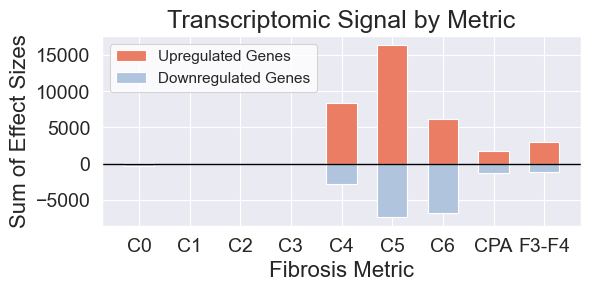

In [16]:
ut.visualize_general_trend(dge_results, effect_size_threshold, p_value_threshold, plots_output_dir)

In [17]:
ut.determine_regulation_trend(significant_genes)

,Total Genes,Upregulated,Downregulated,Upregulated Ratio,Downregulated Ratio,Mean Upregulated Effect Size,Mean Downregulated Effect Size,Weighted Upregulated Score,Weighted Downregulated Score,Combined Weighted Score,Trend
C0,54,4,50,0.074074,0.925926,7.295569,-7.504449,29.182277,-375.222450,-346.040173,Downregulated
C1,0,0,0,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,Balanced
C2,3,0,3,0.000000,1.000000,0.000000,-2.466402,0.000000,-7.399207,-7.399207,Downregulated
C3,1,0,1,0.000000,1.000000,0.000000,-1.088185,0.000000,-1.088185,-1.088185,Downregulated
C4,1716,856,860,0.498834,0.501166,9.744337,-3.343848,8341.152292,-2875.709318,5465.442974,Upregulated
C5,2718,1283,1435,0.472038,0.527962,12.817009,-5.180353,16444.221935,-7433.806549,9010.415385,Upregulated
C6,1475,531,944,0.360000,0.640000,11.641592,-7.219513,6181.685440,-6815.220520,-633.535080,Downregulated
CPA,635,220,415,0.346457,0.653543,7.710638,-3.189908,1696.340431,-1323.811801,372.528630,Upregulated
F3-F4,1993,1149,844,0.576518,0.423482,2.617216,-1.357035,3007.181181,-1145.337437,1861.843744,Upregulated


# Venn Diagrams

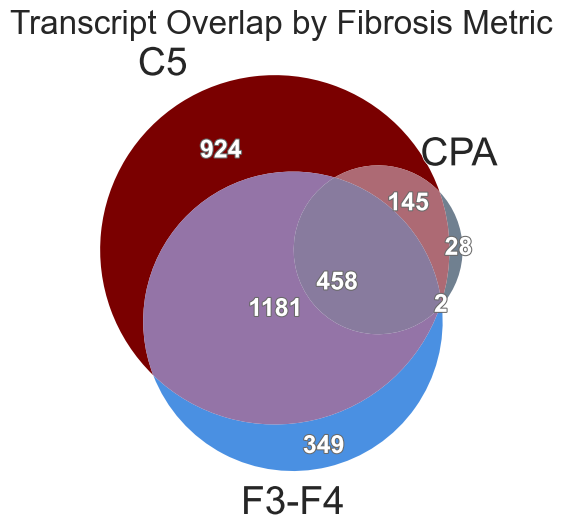

Venn diagram saved as 'fibrosis_dge_interpretation/plots/venn_C5_CPA_F3-F4_ES1_P0.05.png'


In [18]:
selected_labels = ['C5', 'CPA', 'F3-F4']
colour_list = [metric_colours[label] for label in selected_labels if label in metric_colours]
ut.create_cluster_venn(significant_gene_sets, effect_size_threshold, p_value_threshold, selected_labels, plots_output_dir, colour_list, input_type='Genes')

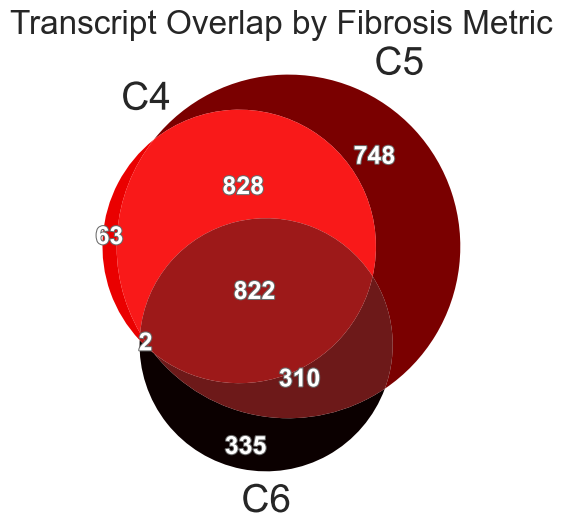

Venn diagram saved as 'fibrosis_dge_interpretation/plots/venn_C4_C5_C6_ES1_P0.05.png'


In [19]:
selected_labels=['C4', 'C5', 'C6']
colour_list = [metric_colours[label] for label in selected_labels if label in metric_colours]
ut.create_cluster_venn(
    significant_gene_sets,
    effect_size_threshold,
    p_value_threshold,
    selected_labels,
    plots_output_dir,
    colors=colour_list,
    text_color='white'  # Makes text inside the circles white
)

# Checking Overlap Significance

In [20]:
gene_overlap_significance = ut.compute_hypergeometric_tests(significant_genes, total_genes)
gene_overlap_significance.to_csv('./fibrosis_dge_interpretation/metric_gene_overlap_significance.csv', index=True)
gene_overlap_significance

,C0,C1,C2,C3,C4,C5,C6,CPA,F3-F4
C0,NaN,1.0,1.000000,1.000000,0.286768,0.630534,9.514032e-01,1.000000e+00,4.323062e-01
C1,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00
C2,1.000000,1.0,NaN,1.000000,0.000977,0.003887,6.205627e-04,3.945333e-03,1.531656e-03
C3,1.000000,1.0,1.000000,NaN,0.099294,1.000000,1.000000e+00,1.000000e+00,1.000000e+00
C4,0.286768,1.0,0.000977,0.099294,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
C5,0.630534,1.0,0.003887,1.000000,0.000000,NaN,0.000000e+00,0.000000e+00,0.000000e+00
C6,0.951403,1.0,0.000621,1.000000,0.000000,0.000000,NaN,0.000000e+00,4.769940e-252
CPA,1.000000,1.0,0.003945,1.000000,0.000000,0.000000,0.000000e+00,NaN,1.524972e-299
F3-F4,0.432306,1.0,0.001532,1.000000,0.000000,0.000000,4.769940e-252,1.524972e-299,NaN


# Effect size comparisons

Plot saved as fibrosis_dge_interpretation/plots/effect_sizes_C5_CPA_F3-F4.png


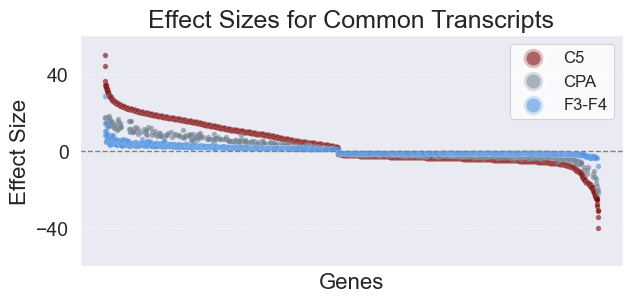

In [21]:
marker_metrics = ut.filter_and_sort_significant_genes(significant_genes,['C5','CPA', 'F3-F4'], sort_by_metric='C5')
ut.plot_gene_effect_sizes(marker_metrics, metric_colours, plots_output_dir, ylims=(-60,60))

Plot saved as fibrosis_dge_interpretation/plots/effect_sizes_C4_C5_C6.png


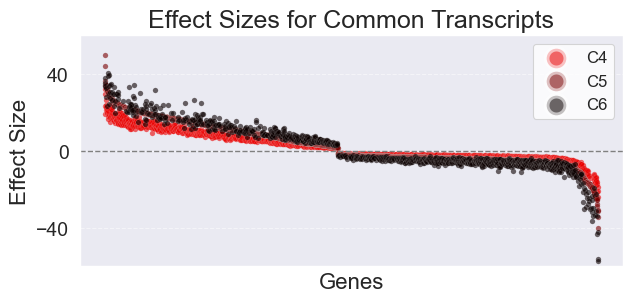

In [22]:
cluster_metrics = ut.filter_and_sort_significant_genes(significant_genes, ['C4','C5','C6'], sort_by_metric='C5')
ut.plot_gene_effect_sizes(cluster_metrics, metric_colours, plots_output_dir, ylims=(-60,60))

# Correlation of DGE effect sizes across fibrosis metrics

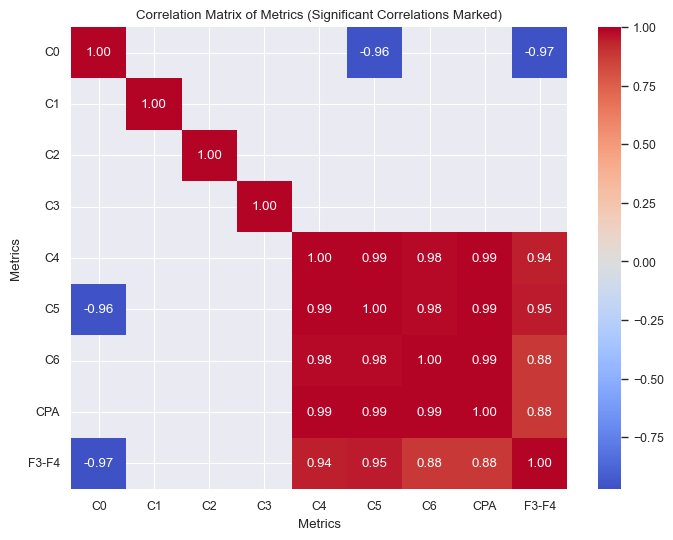

In [23]:
correlation_matrix, p_value_matrix, n_shared_df = ut.compute_metric_correlations(significant_genes, metric_labels)
ut.plot_metric_correlations(correlation_matrix, p_value_matrix, metric_labels)

# Pathway enrichment trends

### Identifying overrepresented pathways

In [24]:
named_significant_genes = ut.filter_named_genes(dge_results)  # Excluding unnamed genes - they trigger errors

In [25]:
significant_pathways = ut.query_reactome_pathways(named_significant_genes, output_dir)  # this takes a while to run

C0: 0 significant pathways
C1: 0 significant pathways
C2: 0 significant pathways
C3: 0 significant pathways
C4: 334 significant pathways
Saved C4 results to fibrosis_dge_interpretation/reactome_results/C4_reactome_results.csv
C5: 430 significant pathways
Saved C5 results to fibrosis_dge_interpretation/reactome_results/C5_reactome_results.csv
C6: 337 significant pathways
Saved C6 results to fibrosis_dge_interpretation/reactome_results/C6_reactome_results.csv
CPA: 216 significant pathways
Saved CPA results to fibrosis_dge_interpretation/reactome_results/CPA_reactome_results.csv
F3-F4: 272 significant pathways
Saved F3-F4 results to fibrosis_dge_interpretation/reactome_results/F3-F4_reactome_results.csv


In [26]:
significant_pathways['C5'].head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,Reactome_Pathways_2024,Metabolism,636/2181,1.434431e-93,2.712509e-90,0,0,3.140504,671.375934,PI4K2B;GLDC;ENO2;ENO3;GLS;PSMD8;GCSH;NDST1;PSM...
1,Reactome_Pathways_2024,Metabolism of Amino Acids and Derivatives,129/358,1.548264e-27,1.463883e-24,0,0,3.738667,230.797871,DMGDH;GLDC;HNMT;SAT1;GLS;TXN2;GCSH;PSMD8;PSMD7...
2,Reactome_Pathways_2024,Biological Oxidations,91/222,2.346602e-24,1.479141e-21,0,0,4.569296,248.611165,UGT1A10;ACY1;TPMT;ACSM1;ACSM2A;MTR;ACSM2B;CNDP...
3,Reactome_Pathways_2024,Fatty Acid Metabolism,74/176,7.783699e-21,3.679743e-18,0,0,4.749241,219.900548,PECR;ACADVL;ACAA2;ACSM3;ECI1;ECI2;TECR;PRKAG2;...
4,Reactome_Pathways_2024,Transport of Small Molecules,190/724,1.187639e-20,4.491650e-18,0,0,2.375577,108.990862,SCARB1;ATP8A2;SLC35B4;STEAP4;TUSC3;AQP9;AQP7;L...


## Fibrosis pathways 
Here you can filter pathways by keywords of your choice.

In [27]:
fibrosis_keywords = ['collagen', 'extracellular matrix', 'ECM', 'fibre', 'fibril', 'fibrosis']

In [28]:
fibrosis_pathways = ut.filter_pathways_by_keywords(significant_pathways, fibrosis_keywords, output_dir)

C4: 14 pathways after filtering
Saved C4 selected pathways to fibrosis_dge_interpretation/filtered_pathways/C4_Fibrosis_pathways.csv
C5: 14 pathways after filtering
Saved C5 selected pathways to fibrosis_dge_interpretation/filtered_pathways/C5_Fibrosis_pathways.csv
C6: 7 pathways after filtering
Saved C6 selected pathways to fibrosis_dge_interpretation/filtered_pathways/C6_Fibrosis_pathways.csv
CPA: 9 pathways after filtering
Saved CPA selected pathways to fibrosis_dge_interpretation/filtered_pathways/CPA_Fibrosis_pathways.csv
F3-F4: 14 pathways after filtering
Saved F3-F4 selected pathways to fibrosis_dge_interpretation/filtered_pathways/F3-F4_Fibrosis_pathways.csv


#### Full list of keyword related pathways

In [29]:
ut.get_unique_pathways(fibrosis_pathways)

['Anchoring Fibril Formation',
 'Assembly of Collagen Fibrils and Other Multimeric Structures',
 'Collagen Biosynthesis and Modifying Enzymes',
 'Collagen Chain Trimerization',
 'Collagen Degradation',
 'Collagen Formation',
 'Crosslinking of Collagen Fibrils',
 'Defective CFTR Causes Cystic Fibrosis',
 'Degradation of the Extracellular Matrix',
 'ECM Proteoglycans',
 'Elastic Fibre Formation',
 'Extracellular Matrix Organization',
 'Molecules Associated With Elastic Fibres',
 'Non-integrin membrane-ECM Interactions']

In [30]:
fibrosis_pathway_effects = ut.compute_pathway_weighted_effect(fibrosis_pathways, named_significant_genes)

#### Select and order pathways for plotting

In [31]:
fibrosis_pathway_order = [#'Extracellular Matrix Organization',

                 #'Collagen Formation',
                 'Collagen Biosynthesis and Modifying Enzymes',
                 'Collagen Chain Trimerization',
                 
                 'Assembly of Collagen Fibrils and Other Multimeric Structures',
                 'Anchoring Fibril Formation',
    
                 'Crosslinking of Collagen Fibrils',
                 'ECM Proteoglycans',
                 'Elastic Fibre Formation',
                          
                 'Degradation of the Extracellular Matrix',
                 'Collagen Degradation',
                 
                 #'Non-integrin membrane-ECM Interactions',
                 #'Molecules Associated With Elastic Fibres',
                 #'Defective CFTR Causes Cystic Fibrosis'
                ]

Plot saved as fibrosis_dge_interpretation/plots/ecm organisation_pathway_enrichment_paper.png


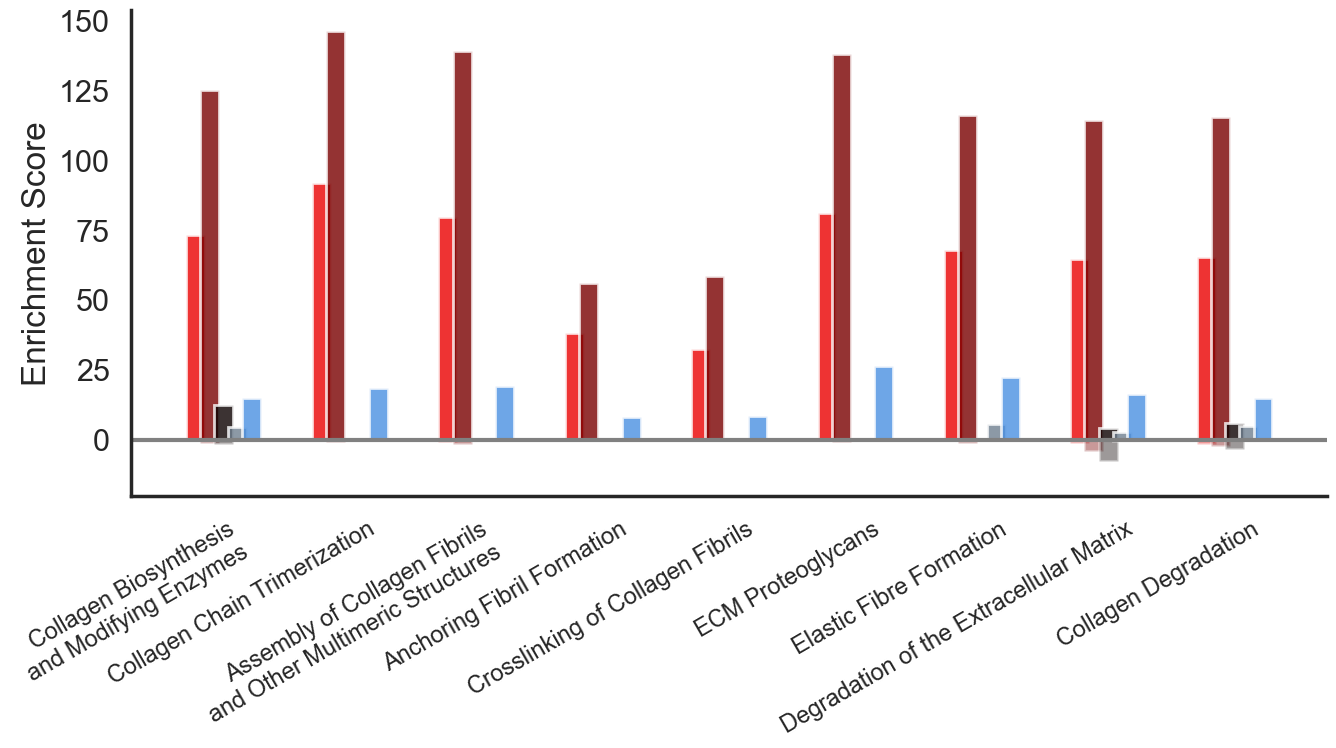

In [32]:
ut.plot_pathway_weighted_enrichment(fibrosis_pathway_effects, metric_colours, plots_output_dir, fibrosis_pathway_order, formatting='paper')

### Number of genes shared between pathways of interest

In [33]:
pathway_genes = ut.extract_pathway_genes(significant_pathways, cluster_key='C5', delimiter=';')
ut.compute_overlap_scores(pathway_genes, fibrosis_pathway_order)

,Collagen Biosynthesis and Modifying Enzymes,Collagen Chain Trimerization,Assembly of Collagen Fibrils and Other Multimeric Structures,Anchoring Fibril Formation,Crosslinking of Collagen Fibrils,ECM Proteoglycans,Elastic Fibre Formation,Degradation of the Extracellular Matrix,Collagen Degradation
Collagen Biosynthesis and Modifying Enzymes,29,24,21,7,7,14,0,22,22
Collagen Chain Trimerization,24,24,21,7,7,14,0,22,22
Assembly of Collagen Fibrils and Other Multimeric Structures,21,21,28,8,9,14,2,25,23
Anchoring Fibril Formation,7,7,8,8,7,7,0,8,7
Crosslinking of Collagen Fibrils,7,7,9,7,9,7,2,7,7
ECM Proteoglycans,14,14,14,7,7,35,7,18,14
Elastic Fibre Formation,0,0,2,0,2,7,22,4,1
Degradation of the Extracellular Matrix,22,22,25,8,7,18,4,47,29
Collagen Degradation,22,22,23,7,7,14,1,29,29


## Major liver functional pathways

In [34]:
selected_general_terms = ['Bile',
                  'Metabolism',
                  'Metabolism of Lipids',
                  'Metabolism of Proteins',
                  'Transport of Small Molecules',
                  'Vesicle-mediated Transport',
                  'Extracellular Matrix Organization',
                  'Complement Cascade',
                  'Hemostasis',
                  'Innate Immune System',
                  'Adaptive Immune System']                  

In [35]:
functional_pathways = ut.filter_pathways_by_keywords(significant_pathways, selected_general_terms, output_dir, domain="Functional")

C4: 47 pathways after filtering
Saved C4 selected pathways to fibrosis_dge_interpretation/filtered_pathways/C4_Functional_pathways.csv
C5: 53 pathways after filtering
Saved C5 selected pathways to fibrosis_dge_interpretation/filtered_pathways/C5_Functional_pathways.csv
C6: 50 pathways after filtering
Saved C6 selected pathways to fibrosis_dge_interpretation/filtered_pathways/C6_Functional_pathways.csv
CPA: 29 pathways after filtering
Saved CPA selected pathways to fibrosis_dge_interpretation/filtered_pathways/CPA_Functional_pathways.csv
F3-F4: 43 pathways after filtering
Saved F3-F4 selected pathways to fibrosis_dge_interpretation/filtered_pathways/F3-F4_Functional_pathways.csv


In [36]:
ut.get_unique_pathways(functional_pathways)

['Adaptive Immune System',
 'Alpha-Linolenic (Omega3) and Linoleic (Omega6) Acid Metabolism',
 'Alpha-Linolenic Acid (ALA) Metabolism',
 'Arachidonate Metabolism',
 'Aspartate and Asparagine Metabolism',
 'Bile Acid and Bile Salt Metabolism',
 'Biotin Transport and Metabolism',
 'Chondroitin Sulfate Dermatan Sulfate Metabolism',
 'Cobalamin (Cbl) Metabolism',
 'Complement Cascade',
 'Creatine Metabolism',
 'Defects in Cobalamin (B12) Metabolism',
 'Defects in Vitamin and Cofactor Metabolism',
 'Diseases Associated With Glycosaminoglycan Metabolism',
 'Diseases of Carbohydrate Metabolism',
 'Diseases of Hemostasis',
 'Diseases of Metabolism',
 'Extracellular Matrix Organization',
 'Fatty Acid Metabolism',
 'Fructose Metabolism',
 'Glutamate and Glutamine Metabolism',
 'Glycogen Metabolism',
 'Glycosaminoglycan Metabolism',
 'Glyoxylate Metabolism and Glycine Degradation',
 'Hemostasis',
 'Heparan Sulfate Heparin (HS-GAG) Metabolism',
 'Hyaluronan Metabolism',
 'Innate Immune System',
 '

In [37]:
functional_pathway_effects = ut.compute_pathway_weighted_effect(functional_pathways, named_significant_genes)

In [38]:
selected_terms_order = [
                  #'Metabolism',
                  'Metabolism of Carbohydrates',
                  'Metabolism of Lipids',
                  'Metabolism of Proteins',
                  'Bile Acid and Bile Salt Metabolism',
                  #'Diseases of Metabolism',
                  'Transport of Small Molecules',
                  'Vesicle-mediated Transport',
                  'Extracellular Matrix Organization',
                  'Hemostasis',
                  'Complement Cascade',
                  'Innate Immune System',
                  'Adaptive Immune System']   

In [39]:
pathways_to_rename = {'Bile Acid and Bile Salt Metabolism':'Bile Acid Metabolism'}
pathways_to_bold = ['Extracellular Matrix Organization']

Plot saved as fibrosis_dge_interpretation/plots/functional_pathway_enrichment_paper.png


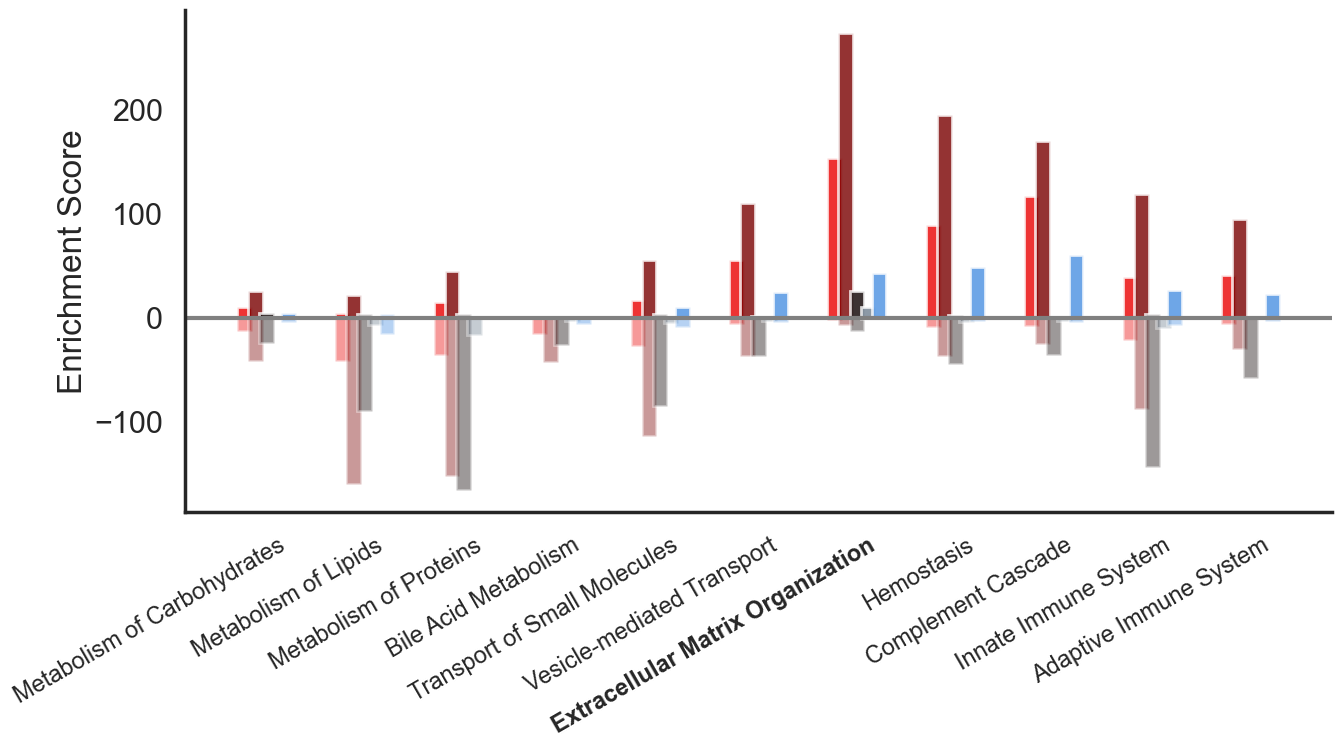

In [40]:
ut.plot_pathway_weighted_enrichment(functional_pathway_effects, metric_colours, plots_output_dir, selected_terms_order, pathways_to_rename, pathways_to_bold, domain="Functional", formatting='paper')

Legend saved as fibrosis_dge_interpretation/plots/metrics_legend.png


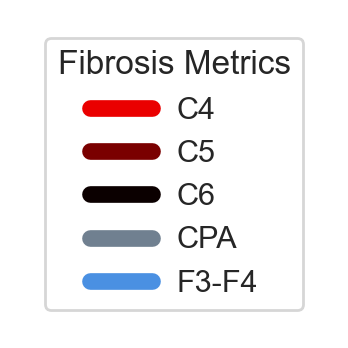

In [41]:
ut.plot_only_legend(metric_colours, plots_output_dir)

### Number of novel transcripts
"Novel" = the gene name contains the word "novel"

In [42]:
novel_counts, novel_genes = ut.count_novel_genes(significant_genes)
#novel_genes['C5']

Cluster C0: 1 significant genes containing 'novel'
Cluster C1: 0 significant genes containing 'novel'
Cluster C2: 0 significant genes containing 'novel'
Cluster C3: 0 significant genes containing 'novel'
Cluster C4: 6 significant genes containing 'novel'
Cluster C5: 17 significant genes containing 'novel'
Cluster C6: 11 significant genes containing 'novel'
Cluster CPA: 4 significant genes containing 'novel'
Cluster F3-F4: 7 significant genes containing 'novel'


In [43]:
ut.count_unique_novel_genes(novel_genes)

Total unique novel genes across all clusters: 27


27

# Top n genes by largest effect size

In [44]:
top_n = 10

## Upregulated genes

In [45]:
summary_table_upregulated = ut.create_summary_table(fibrosis_marker_genes, top_n)
summary_table_upregulated = ut.fill_missing_values(summary_table_upregulated, dge_results)
summary_table_upregulated.to_csv(f'{output_dir}/significant_DEGs/summary_table_upregulated_top_{top_n}.csv', index=True)

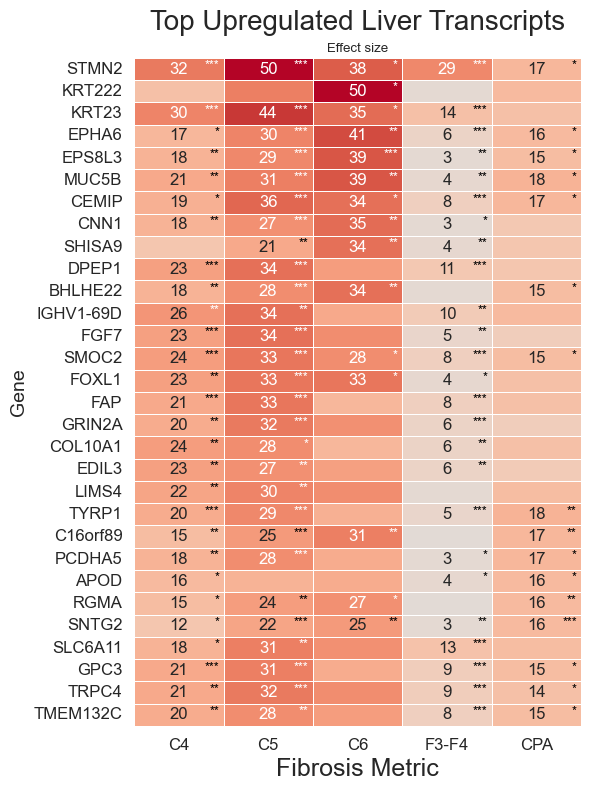

In [46]:
ut.plot_top_genes_heatmap(
    summary_table_upregulated,
    ['C4 Effect Size','C5 Effect Size','C6 Effect Size','F3-F4 Effect Size','CPA Effect Size'],
    ['C4 adj.P.Val','C5 adj.P.Val','C6 adj.P.Val','F3-F4 adj.P.Val','CPA adj.P.Val'],
    output_path=f'{output_dir}/plots/top_{top_n}_upregulated_genes_heatmap.png',
    title="Top Upregulated Liver Transcripts",
    cmap='coolwarm',
    bold_genes=[],
    rename_genes={"ENSG00000264058": "KRT222"}
    )

## Downregulated genes

In [47]:
summary_table_downregulated = ut.create_summary_table(fibrosis_marker_genes, top_n, downregulated=True)
summary_table_downregulated = ut.fill_missing_values(summary_table_downregulated, dge_results)
summary_table_downregulated.to_csv(f'{output_dir}/significant_DEGs/summary_table_downregulated_top_{top_n}.csv', index=True)

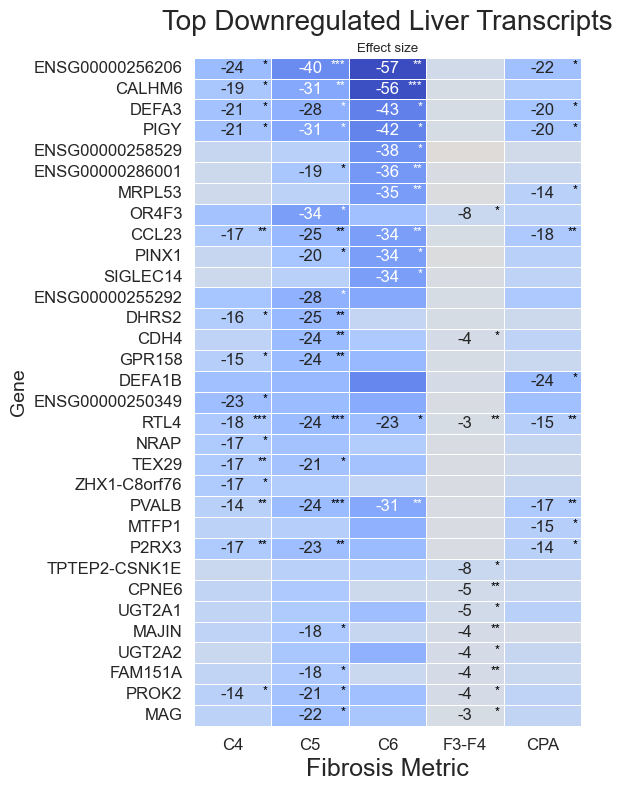

In [48]:
ut.plot_top_genes_heatmap(
    summary_table_downregulated,
    ['C4 Effect Size','C5 Effect Size','C6 Effect Size','F3-F4 Effect Size','CPA Effect Size'],
    ['C4 adj.P.Val','C5 adj.P.Val','C6 adj.P.Val','F3-F4 adj.P.Val','CPA adj.P.Val'],
    output_path=f'{output_dir}/plots/top_{top_n}_downregulated_genes_heatmap.png',
    title="Top Downregulated Liver Transcripts",
    cmap='coolwarm',
    )

# Jaccard index between top molecules

In [49]:
jaccard_up_df = ut.jaccard_top_effect_genes(significant_genes, 'C5', ['C4', 'C6', 'CPA', 'F3-F4'], 100, "up")
jaccard_up_df

,Jaccard_index,intersection,union
C4,0.639344,78,122
F3-F4,0.459854,63,137
CPA,0.190476,32,168
C6,0.176471,30,170


In [50]:
jaccard_down_df = ut.jaccard_top_effect_genes(significant_genes, 'C5', ['C4', 'C6', 'CPA', 'F3-F4'], 100, "down")
jaccard_down_df

,Jaccard_index,intersection,union
C4,0.257862,41,159
C6,0.197605,33,167
F3-F4,0.169591,29,171
CPA,0.098901,18,182
